# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
import math
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, IntegerType
from pyspark.sql.functions import desc, asc, sum, avg, col, concat, desc, explode, lit, min, max, split, udf,isnan, when, \
count, col


from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, \
StringIndexer, VectorAssembler, Imputer, OneHotEncoder, MinMaxScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


import datetime

import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
#from sklearn.preprocessing import Imputer
#from sklearn import impute
#NOTE!!! FOR THE NEXT LINE TO RUN... MUST 
#pip install scikit-learn==0.23.2, then restart kernal!!!!!!!
#https://knowledge.udacity.com/questions/662415
#from sklearn.impute import SimpleImputer, KNNImputer

#cant get fancyimpute to work!!! 
#from sklearn.preprocessing.imputation import SimpleImputer
# importing the KNN from fancyimpute library
#from fancyimpute import KNN

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Wrangling Data") \
    .getOrCreate()

# 2. Data Understanding

##  Data Exploration

In [3]:
path = "mini_sparkify_event_data.json"
user_log = spark.read.json(path)

In [4]:
user_log.head(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [5]:
user_log.filter(user_log.page == 'Error').show(n=5)

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+-----+-------------+---------+----+------+-------------+--------------------+------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method| page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+-----+-------------+---------+----+------+-------------+--------------------+------+
|  null|Logged In|     Kael|     M|           48|   Baker|  null| paid|Kingsport-Bristol...|   GET|Error|1533102330000|      249|null|   404|1538393848000|"Mozilla/5.0 (Mac...|   131|
|  null|Logged In|   Lucero|     F|           10|    Reed|  null| free|Louisville/Jeffer...|   GET|Error|1536642109000|      139|null|   404|1538407927000|"Mozilla/5.0 (Win...|   140|
|  null|Logged In|Sebastian|     M|           38|    Wang|  null| free|         

In [8]:
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [9]:
user_log.count()

286500

In [10]:
#identify count of nulls, all columns
#user_log_valid = user_log.dropna(how = "any", subset = ["userId", "sessionId"])
#https://sparkbyexamples.com/spark/spark-filter-rows-with-null-values/
#https://stackoverflow.com/questions/44627386/how-to-find-count-of-null-and-nan-values-for-each-column-in-a-pyspark-dataframe

#looks like artist, length, song is null in 58,392 recs (~20% of the data set)
#first name, last name, gender, location, registration 8346 recs (~3% of the data set)
#hames don't seem as important to use with predictive modeling of who will cancel. Will drop from features
#Location, gender, registration is important. Though 3% loss
#Thought about imputing with nearest neighbor (link below). Will stick with mode
#https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html
#https://www.kaggle.com/hafsaezzahraouy/dealing-with-missing-data-with-pyspark
#https://www.geeksforgeeks.org/missing-data-imputation-with-fancyimpute/

user_log.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in user_log.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [11]:
#distinct values for colums with nulls: 
#artist characters, 17656 distinct
#gender chars, 3 values, M/F/Null
#length is numeric with 14866 distinct values; 
#registration is numeric with 226 distinct values
#song is chars with 58481 distinct values
#userAgent is chars with 57 distinct values

#One Hot Encoding with artist and song will create too many dimensions...we will not do that with those columns.

user_log.select('registration').distinct().count()

226

In [23]:
user_log.select("artist").distinct().count()

17656

In [36]:
user_log.select("gender").distinct().show()

+------+
|gender|
+------+
|     F|
|  null|
|     M|
+------+



In [28]:
user_log.select("length").distinct().count()

14866

In [37]:
user_log.select("method").distinct().show()

+------+
|method|
+------+
|   PUT|
|   GET|
+------+



In [29]:
user_log.select("song").distinct().count()

58481

In [30]:
user_log.select("userAgent").distinct().count()

57

In [43]:
user_log.select("auth").distinct().show()

+----------+
|      auth|
+----------+
|Logged Out|
| Cancelled|
|     Guest|
| Logged In|
+----------+



In [38]:
user_log.select('itemInSession').distinct().count()

1322

In [39]:
user_log.select('sessionId').distinct().count()

2354

In [35]:
user_log.select('status').distinct().show()

+------+
|status|
+------+
|   307|
|   404|
|   200|
+------+



In [41]:
#there are only 115 distinct locations. This should not be too much of an issue for dimensionality 
user_log.select('location').distinct().count()

115

In [12]:
#lets see what types of page actions occur when artist, song, length are null
#checked all 3, all 3 show 21 of 22 distinct page actions. 

#tricky decision here, but to effecively use OHE without curse of dimensionality with artist/song char cols will drop these 2,
#along with customer first and last name  song length 
user_log.select("page").distinct().filter(col("length").isNull()).count()

21

In [13]:
user_log.select("page").distinct().count()

22

In [41]:
user_log.select("page").distinct().collect()

[Row(page='Cancel'),
 Row(page='Submit Downgrade'),
 Row(page='Thumbs Down'),
 Row(page='Home'),
 Row(page='Downgrade'),
 Row(page='Roll Advert'),
 Row(page='Logout'),
 Row(page='Save Settings'),
 Row(page='Cancellation Confirmation'),
 Row(page='About'),
 Row(page='Submit Registration'),
 Row(page='Settings'),
 Row(page='Login'),
 Row(page='Register'),
 Row(page='Add to Playlist'),
 Row(page='Add Friend'),
 Row(page='NextSong'),
 Row(page='Thumbs Up'),
 Row(page='Help'),
 Row(page='Upgrade'),
 Row(page='Error'),
 Row(page='Submit Upgrade')]

In [11]:
#drop first and last name, artist, song, length
#df = user_log.drop(*('firstName','lastName', 'artist', 'song'))

## Data Preparation (pre-analysis)

In [4]:
#DATA PREP PRE-ANALYSIS
#will keep columns that are pertinant and will not cause too much dimensionality when modeling:

#char columns to keep: gender, level, page, location
#numeric to keep: length, status, ts (will extract day of week and hour)

df2 = user_log.select("userid","gender","level","page","location","length","status","ts","sessionId")

In [160]:
df2.show(n=5)

+------+------+-----+--------+--------------------+---------+------+-------------+---------+
|userid|gender|level|    page|            location|   length|status|           ts|sessionId|
+------+------+-----+--------+--------------------+---------+------+-------------+---------+
|    30|     M| paid|NextSong|     Bakersfield, CA|277.89016|   200|1538352117000|       29|
|     9|     M| free|NextSong|Boston-Cambridge-...|236.09424|   200|1538352180000|        8|
|    30|     M| paid|NextSong|     Bakersfield, CA| 282.8273|   200|1538352394000|       29|
|     9|     M| free|NextSong|Boston-Cambridge-...|262.71302|   200|1538352416000|        8|
|    30|     M| paid|NextSong|     Bakersfield, CA|223.60771|   200|1538352676000|       29|
+------+------+-----+--------+--------------------+---------+------+-------------+---------+
only showing top 5 rows



In [5]:
#extract day of week and hour from ts
from pyspark.sql.functions import *
#Convert timestamp to unix timestamp

#https://stackoverflow.com/questions/45977449/convert-timestamp-to-date-in-spark-dataframe
get_timestamp = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
df2 = df2.withColumn("datetime", get_timestamp(df2.ts))

#https://stackoverflow.com/questions/45977449/convert-timestamp-to-date-in-spark-dataframe
#df2 = df.withColumn("date", to_date("datetime"))
df2 = df2.withColumn("date",to_date("datetime"))
#https://www.datasciencemadesimple.com/get-week-number-from-date-in-pyspark/#:~:text=Extract%20day%20of%20week%20from%20date%20in%20words,%E2%80%9CEEEE%E2%80%9D%20which%20returns%20the%20week%20name%20in%20character.
#1 = Sunday, 2 = Monday ...7=saturday
df2 = df2.withColumn("day_of_week",dayofweek("date"))

import pyspark.sql.functions as F
from pyspark.sql.types import IntegerType

df2 = df2.withColumn("hour", hour(col("datetime")))
#https://www.datasciencemadesimple.com/get-day-of-month-day-of-year-day-of-week-from-date-in-pyspark/
df2 = df2.withColumn('day_of_month',dayofmonth(df2.date))



In [6]:
df2.show(n=4)

+------+------+-----+--------+--------------------+---------+------+-------------+---------+-------------------+----------+-----------+----+------------+
|userid|gender|level|    page|            location|   length|status|           ts|sessionId|           datetime|      date|day_of_week|hour|day_of_month|
+------+------+-----+--------+--------------------+---------+------+-------------+---------+-------------------+----------+-----------+----+------------+
|    30|     M| paid|NextSong|     Bakersfield, CA|277.89016|   200|1538352117000|       29|2018-10-01 00:01:57|2018-10-01|          2|   0|           1|
|     9|     M| free|NextSong|Boston-Cambridge-...|236.09424|   200|1538352180000|        8|2018-10-01 00:03:00|2018-10-01|          2|   0|           1|
|    30|     M| paid|NextSong|     Bakersfield, CA| 282.8273|   200|1538352394000|       29|2018-10-01 00:06:34|2018-10-01|          2|   0|           1|
|     9|     M| free|NextSong|Boston-Cambridge-...|262.71302|   200|15383524

In [6]:
#extract state from location
#https://stackoverflow.com/questions/59238807/how-to-use-substrin-and-instr-together-pyspark
#https://sparkbyexamples.com/pyspark/pyspark-substring-from-a-column
#https://www.datasciencemadesimple.com/extract-first-n-and-last-n-character-in-pyspark/
#split city and state
df2 = df2.withColumn("State", df2.location.substr(-2,2))
df2.show(n=3)

+------+------+-----+--------+--------------------+---------+------+-------------+---------+-------------------+----------+-----------+----+------------+-----+
|userid|gender|level|    page|            location|   length|status|           ts|sessionId|           datetime|      date|day_of_week|hour|day_of_month|State|
+------+------+-----+--------+--------------------+---------+------+-------------+---------+-------------------+----------+-----------+----+------------+-----+
|    30|     M| paid|NextSong|     Bakersfield, CA|277.89016|   200|1538352117000|       29|2018-10-01 00:01:57|2018-10-01|          2|   0|           1|   CA|
|     9|     M| free|NextSong|Boston-Cambridge-...|236.09424|   200|1538352180000|        8|2018-10-01 00:03:00|2018-10-01|          2|   0|           1|   NH|
|    30|     M| paid|NextSong|     Bakersfield, CA| 282.8273|   200|1538352394000|       29|2018-10-01 00:06:34|2018-10-01|          2|   0|           1|   CA|
+------+------+-----+--------+----------

In [60]:
df2.count()

286500

In [ ]:
#identify rows having  page 'Cancellation Confirmation' put into 1 dataset
#identify rows 'not' having page 'Cancellation Confirmation' put into 1 dataset

#join these 2 datasets to identify behaviurs of customers who cancelled vs customers who are active

##  Data Visualization

In [9]:
#drop nulls for analysis (lost ~20% of original set...ok for pre-analysis)
df_analysis = df2.na.drop()
df_analysis.count()

228108

In [10]:
#spark df to pandas df for charts
df_an_pd = df_analysis.toPandas()

(<matplotlib.axes._subplots.AxesSubplot at 0x7fdb61781c88>,
 count    228108.000000
 mean        249.117182
 std          99.235179
 min           0.783220
 25%         199.888530
 50%         234.500770
 75%         277.158730
 max        3024.665670
 Name: length, dtype: float64)

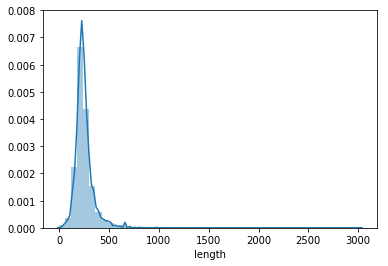

In [28]:
#distribution of length of action
#average length is 249, 
df_an_pd_len = df_an_pd.length.copy()
sns.distplot(df_an_pd_len), df_an_pd_len.describe()

In [62]:
#count of users by location (state)
#users by gender
df_analysis.groupBy("State").agg(countDistinct(df_analysis.userid).alias("dist_tots")).sort(col("dist_tots").desc()).show()

+-----+---------+
|State|dist_tots|
+-----+---------+
|   CA|       33|
|   PA|       18|
|   TX|       16|
|   FL|       14|
|   WI|       10|
|   NC|        9|
|   IL|        9|
|   SC|        8|
|   MD|        7|
|   NH|        7|
|   AZ|        7|
|   CT|        7|
|   IN|        6|
|   WV|        6|
|   WA|        6|
|   AL|        6|
|   NY|        5|
|   MI|        5|
|   GA|        4|
|   CO|        4|
+-----+---------+
only showing top 20 rows



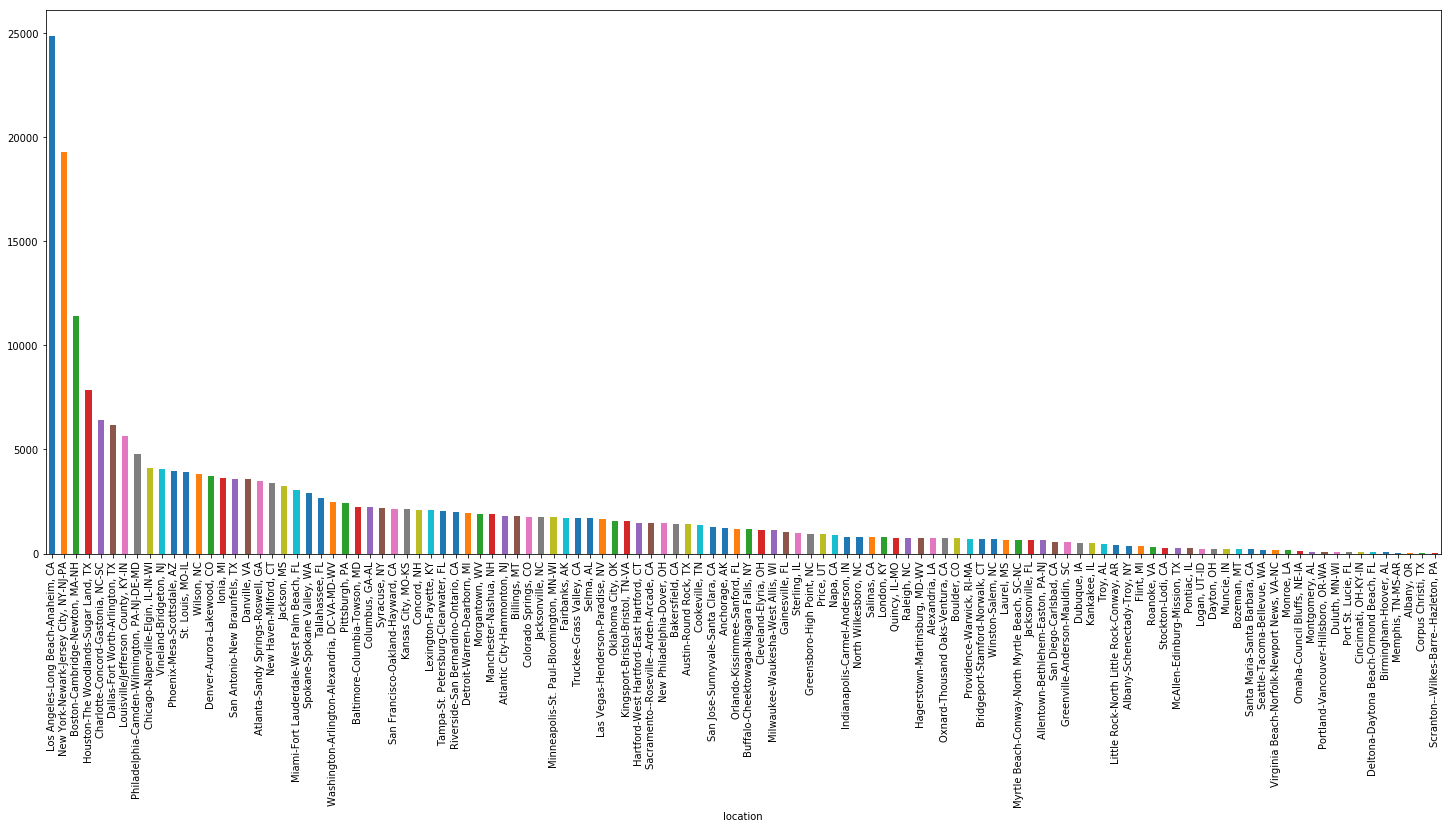

In [30]:
#count of users by location (city and state)
df_an_pd_loc = df_an_pd.groupby(['location'],as_index=False).size().reset_index(name='Totals')
df_an_pd_loc.groupby('location')['Totals'].sum().sort_values(ascending=False).plot(kind='bar',figsize=(25,10));

In [12]:
#users by gender
df_analysis.groupBy("gender").agg(countDistinct(df_analysis.userid).alias("dist_tots")).show()

+------+---------+
|gender|dist_tots|
+------+---------+
|     F|      104|
|     M|      121|
+------+---------+



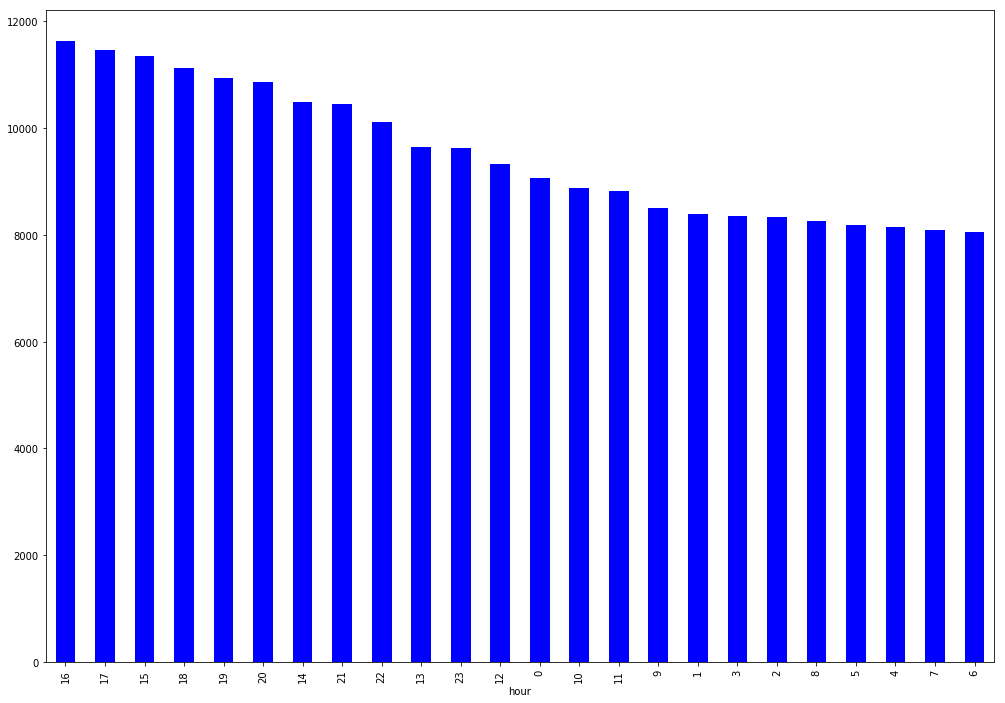

In [11]:
#Totals by Hour: most PM users
df_an_pd_hr = df_an_pd.groupby(['hour'],as_index=False).size().reset_index(name='Totals')
df_an_pd_hr.groupby('hour')['Totals'].sum().sort_values(ascending=False).plot(kind='bar',figsize=(17,12), color=['blue']);

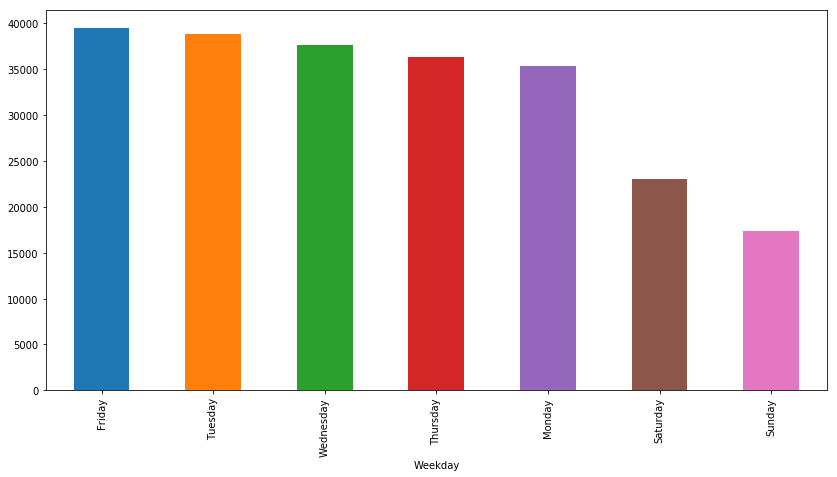

In [37]:
#Totals by day of week- most heavy listeners mon-fri
df_an_pd_d = df_an_pd.groupby(['day_of_week'],as_index=False).size().reset_index(name='Totals')

df_an_pd_d['Weekday'] = np.select(
    [
        df_an_pd_d['day_of_week'] == 1, 
        df_an_pd_d['day_of_week'] == 2,
        df_an_pd_d['day_of_week'] == 3,
        df_an_pd_d['day_of_week'] == 4,
        df_an_pd_d['day_of_week'] == 5,
        df_an_pd_d['day_of_week'] == 6,
        df_an_pd_d['day_of_week'] == 7,
    ], 
    [
        'Sunday', 
        'Monday', 
        'Tuesday',
        'Wednesday',
        'Thursday',
        'Friday',
        'Saturday',
    ], 
    default='Unknown'
)

df_an_pd_d.groupby('Weekday')['Totals'].sum().sort_values(ascending=False).plot(kind='bar',figsize=(14,7));

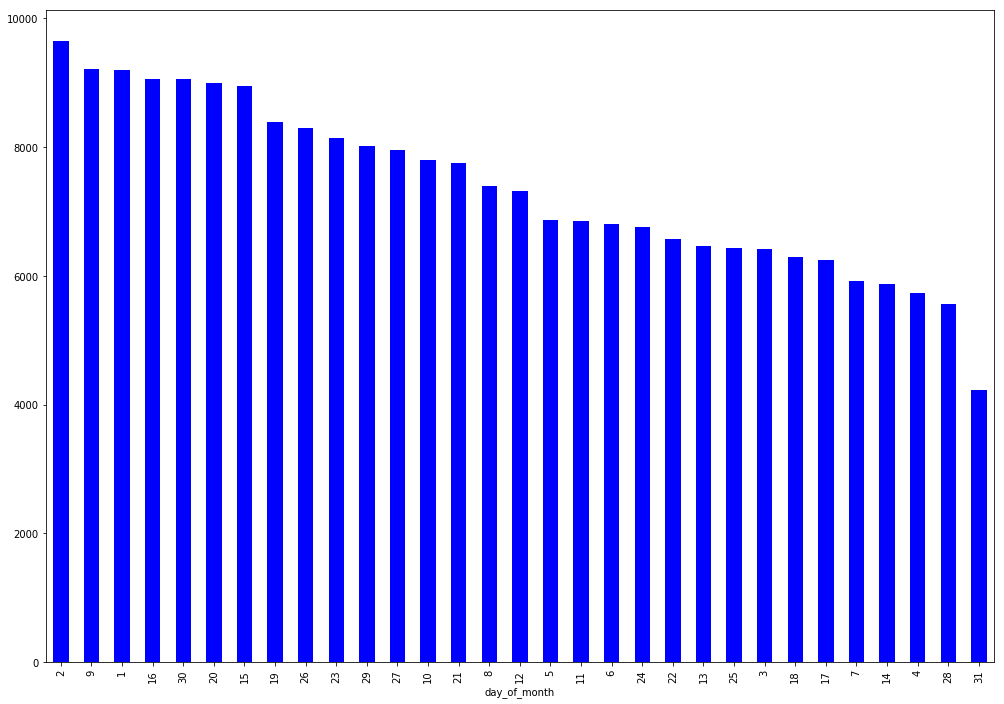

In [14]:
#Totals by day of month
df_an_pd_dow = df_an_pd.groupby(['day_of_month'],as_index=False).size().reset_index(name='Totals')
df_an_pd_dow.groupby('day_of_month')['Totals'].sum().sort_values(ascending=False).plot(kind='bar',figsize=(17,12), color=['blue']);

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn
Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

In [16]:
df2.select("page").distinct().collect()

[Row(page='Cancel'),
 Row(page='Submit Downgrade'),
 Row(page='Thumbs Down'),
 Row(page='Home'),
 Row(page='Downgrade'),
 Row(page='Roll Advert'),
 Row(page='Logout'),
 Row(page='Save Settings'),
 Row(page='Cancellation Confirmation'),
 Row(page='About'),
 Row(page='Submit Registration'),
 Row(page='Settings'),
 Row(page='Login'),
 Row(page='Register'),
 Row(page='Add to Playlist'),
 Row(page='Add Friend'),
 Row(page='NextSong'),
 Row(page='Thumbs Up'),
 Row(page='Help'),
 Row(page='Upgrade'),
 Row(page='Error'),
 Row(page='Submit Upgrade')]

In [64]:
df2.columns

['userid',
 'gender',
 'level',
 'page',
 'location',
 'length',
 'status',
 'ts',
 'datetime',
 'date',
 'day_of_week',
 'hour',
 'day_of_month',
 'State']

In [65]:
df2.printSchema()

root
 |-- userid: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- level: string (nullable = true)
 |-- page: string (nullable = true)
 |-- location: string (nullable = true)
 |-- length: double (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- datetime: string (nullable = true)
 |-- date: date (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- day_of_month: integer (nullable = true)
 |-- State: string (nullable = true)



In [7]:
#udf, label for churn and crate new col for page val cxl conf
churn_y_n = udf(lambda x : 1 if x=='Cancellation Confirmation' else 0, IntegerType())

In [8]:
df2 = df2.withColumn('Churn_Label', churn_y_n('page'))

In [30]:
df2.filter(df2.Churn_Label == 1).show(n=2)

+------+------+-----+--------------------+--------------------+------+------+-------------+---------+-------------------+----------+-----------+----+------------+-----+-----------+
|userid|gender|level|                page|            location|length|status|           ts|sessionId|           datetime|      date|day_of_week|hour|day_of_month|State|Churn_Label|
+------+------+-----+--------------------+--------------------+------+------+-------------+---------+-------------------+----------+-----------+----+------------+-----+-----------+
|    18|     M| paid|Cancellation Conf...|  Kansas City, MO-KS|  null|   200|1538943990000|      514|2018-10-07 20:26:30|2018-10-07|          1|  20|           7|   KS|          1|
|    32|     M| paid|Cancellation Conf...|Phoenix-Mesa-Scot...|  null|   200|1539033046000|      540|2018-10-08 21:10:46|2018-10-08|          2|  21|           8|   AZ|          1|
+------+------+-----+--------------------+--------------------+------+------+-------------+----

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [10]:
#spark df to pandas df for charts
df_an_pd_ch = df2.toPandas()

In [66]:
#Total Churn vs did not churn; there is roughly a 20% churn rate among distinct users
df2.groupBy("Churn_Label").agg(countDistinct(df2.userid).alias("Totals")).show()

+-----------+------+
|Churn_Label|Totals|
+-----------+------+
|          1|    52|
|          0|   226|
+-----------+------+



In [69]:
#total churn vs did not churn by gender; even breakout
df2.groupBy("Churn_Label","gender").agg(countDistinct(df2.userid).alias("Totals")).sort(col("Totals").desc()).show()

+-----------+------+------+
|Churn_Label|gender|Totals|
+-----------+------+------+
|          0|     M|   121|
|          0|     F|   104|
|          1|     M|    32|
|          1|     F|    20|
|          0|  null|     1|
+-----------+------+------+



In [70]:
#total churn vs did not churn by free vs paid accts; pretty even breakdown
df2.groupBy("Churn_Label","level").agg(countDistinct(df2.userid).alias("Totals")).sort(col("Totals").desc()).show()

+-----------+-----+------+
|Churn_Label|level|Totals|
+-----------+-----+------+
|          0| free|   196|
|          0| paid|   166|
|          1| paid|    31|
|          1| free|    21|
+-----------+-----+------+



In [73]:
#total churn vs did not churn by free vs paid accts. Most customers in CA and PA
df2.groupBy("Churn_Label","state").agg(countDistinct(df2.userid).alias("Totals")).sort(col("Totals").desc()).show()

+-----------+-----+------+
|Churn_Label|state|Totals|
+-----------+-----+------+
|          0|   CA|    33|
|          0|   PA|    18|
|          0|   TX|    16|
|          0|   FL|    14|
|          0|   WI|    10|
|          0|   IL|     9|
|          0|   NC|     9|
|          0|   SC|     8|
|          0|   AZ|     7|
|          0|   MD|     7|
|          0|   NH|     7|
|          0|   CT|     7|
|          1|   CA|     6|
|          0|   AL|     6|
|          0|   WV|     6|
|          0|   IN|     6|
|          0|   WA|     6|
|          0|   MI|     5|
|          0|   NY|     5|
|          1|   PA|     5|
+-----------+-----+------+
only showing top 20 rows



In [74]:
#total churn vs did not churn by free vs paid accts
df2.groupBy("Churn_Label","location").agg(countDistinct(df2.userid).alias("Totals")).sort(col("Totals").desc()).collect()

[Row(Churn_Label=0, location='Los Angeles-Long Beach-Anaheim, CA', Totals=16),
 Row(Churn_Label=0, location='New York-Newark-Jersey City, NY-NJ-PA', Totals=15),
 Row(Churn_Label=0, location='Dallas-Fort Worth-Arlington, TX', Totals=7),
 Row(Churn_Label=0, location='Phoenix-Mesa-Scottsdale, AZ', Totals=7),
 Row(Churn_Label=0, location='St. Louis, MO-IL', Totals=6),
 Row(Churn_Label=0, location='Charlotte-Concord-Gastonia, NC-SC', Totals=6),
 Row(Churn_Label=0, location='Chicago-Naperville-Elgin, IL-IN-WI', Totals=6),
 Row(Churn_Label=0, location='Miami-Fort Lauderdale-West Palm Beach, FL', Totals=5),
 Row(Churn_Label=0, location='Philadelphia-Camden-Wilmington, PA-NJ-DE-MD', Totals=5),
 Row(Churn_Label=0, location='Boston-Cambridge-Newton, MA-NH', Totals=5),
 Row(Churn_Label=1, location='New York-Newark-Jersey City, NY-NJ-PA', Totals=5),
 Row(Churn_Label=0, location='Atlanta-Sandy Springs-Roswell, GA', Totals=4),
 Row(Churn_Label=0, location='Houston-The Woodlands-Sugar Land, TX', Total

(<matplotlib.axes._subplots.AxesSubplot at 0x7f66b8d30978>,
 count    228108.000000
 mean        249.117182
 std          99.235179
 min           0.783220
 25%         199.888530
 50%         234.500770
 75%         277.158730
 max        3024.665670
 Name: length, dtype: float64)

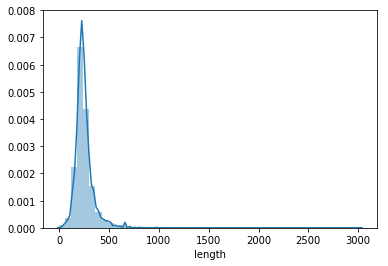

In [75]:
#distribution of length
#looks like average length is 249, 
df_an_pd_len2 = df_an_pd_ch.length.dropna()
sns.distplot(df_an_pd_len2), df_an_pd_len2.describe()

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [9]:
#drop nans for features
df3 = df2.na.drop()

In [10]:
# for features which exist while customer is not cancelled...identify location, state, percentage of AM/PM use,
#Percentage of Weekend/Weekday use (all actions except cancel and cancel conf)
df3.createOrReplaceTempView("dfx")

df_feat1 = spark.sql('''
        select b.userid, 
        max(b.gender) as gender, max(b.level) as level, max(b.location) as location, 
        max(b.state) as state, sum(b.AM_Use) as AM_Use, sum(b.PM_Use) as PM_Use,
        sum(b.Weekday_Use) as Weekday_Use, sum(b.Weekend_Use) as Weekend_Use from 
    
        
        (select userid, gender, level, location, state,
        
        CASE when hour between 0 and 11 then 1 else 0 end as AM_Use,
        CASE when hour between 12 and 23 then 1 else 0 end as PM_Use,
        
        CASE when day_of_week in (2,3,4,5,6) then 1 else 0 end as Weekday_Use,
        CASE when day_of_week in (1,7) then 1 else 0 end as Weekend_Use
        
        from dfx where page in ('Submit Downgrade', 'Thumbs Down', 'Home', 'Downgrade', 'Roll Advert', 'Logout', 
        'Save Settings', 'About', 'Submit Registration', 'Settings', 'Login', 'Register', 'Add to Playlist', 'Add Friend', 
        'NextSong', 'Thumbs Up', 'Help', 'Upgrade', 'Error', 'Submit Upgrade')
        
        ) b group by userid
''')

In [182]:
df_feat1.show(n=10)

+------+------+-----+--------------------+-----+------+------+-----------+-----------+
|userid|gender|level|            location|state|AM_Use|PM_Use|Weekday_Use|Weekend_Use|
+------+------+-----+--------------------+-----+------+------+-----------+-----------+
|100010|     F| free|Bridgeport-Stamfo...|   CT|   119|   156|        231|         44|
|200002|     M| paid|Chicago-Napervill...|   WI|    83|   304|        387|          0|
|   125|     M| free|  Corpus Christi, TX|   TX|     8|     0|          8|          0|
|   124|     F| paid|Vineland-Bridgeto...|   NJ|  1679|  2400|       3581|        498|
|    51|     M| paid|Lexington-Fayette...|   KY|  1008|  1103|       1965|        146|
|     7|     M| free|Seattle-Tacoma-Be...|   WA|    83|    67|        150|          0|
|    15|     M| paid|      Morgantown, WV|   WV|   687|  1227|       1455|        459|
|    54|     F| paid|Spokane-Spokane V...|   WA|  1145|  1696|       2263|        578|
|   155|     F| paid|Boston-Cambridge-...| 

In [11]:
#calculate percentage of use (AM/PM) and Weekday/Weekend from prior feature set, rounded to nearest 10's digit perc
#df_feat1.withColumn('Perc_AM', (df_feat1.AM_Use/(df_feat1.AM_Use+df_feat1.PM_Use))*100).show(n=2)
df_feat1 = df_feat1.withColumn('Perc_AM',  round(((df_feat1.AM_Use/(df_feat1.AM_Use+df_feat1.PM_Use))*100),-1 ))
df_feat1 = df_feat1.withColumn('Perc_PM',  round(((df_feat1.PM_Use/(df_feat1.AM_Use+df_feat1.PM_Use))*100),-1 ))
df_feat1 = df_feat1.withColumn('Perc_Wkday',  round(((df_feat1.Weekday_Use/(df_feat1.Weekday_Use+df_feat1.Weekend_Use))*100),-1 ))
df_feat1 = df_feat1.withColumn('Perc_Wknd',  round(((df_feat1.Weekend_Use/(df_feat1.Weekday_Use+df_feat1.Weekend_Use))*100),-1 ))

In [12]:
df_feat1 = df_feat1.select("userid","gender","level","location","state","Perc_AM","Perc_PM","Perc_Wkday","Perc_Wknd")

In [16]:
df_feat1.show(n=2)

+------+------+-----+--------------------+-----+-------+-------+----------+---------+
|userid|gender|level|            location|state|Perc_AM|Perc_PM|Perc_Wkday|Perc_Wknd|
+------+------+-----+--------------------+-----+-------+-------+----------+---------+
|100010|     F| free|Bridgeport-Stamfo...|   CT|   40.0|   60.0|      80.0|     20.0|
|200002|     M| paid|Chicago-Napervill...|   WI|   20.0|   80.0|     100.0|      0.0|
+------+------+-----+--------------------+-----+-------+-------+----------+---------+
only showing top 2 rows



In [237]:
df_feat1.count()

225

In [243]:
df2.select('userid').filter(df2.Churn_Label == 1)

52

In [13]:
#join feature data set back to df2 to find churn_label
df2_dist_u = df2.select('userid','Churn_Label').withColumnRenamed('userid', 'userid_lab').distinct()

In [254]:
df2_dist_u.count()

278

In [14]:
df4 = df2_dist_u.join(df_feat1, (df2_dist_u.userid_lab == df_feat1.userid), how = "inner")

In [257]:
df4.count()

277

In [20]:
df4.show(n=3)

+----------+-----------+------+------+-----+--------------------+-----+-------+-------+----------+---------+
|userid_lab|Churn_Label|userid|gender|level|            location|state|Perc_AM|Perc_PM|Perc_Wkday|Perc_Wknd|
+----------+-----------+------+------+-----+--------------------+-----+-------+-------+----------+---------+
|    100010|          0|100010|     F| free|Bridgeport-Stamfo...|   CT|   40.0|   60.0|      80.0|     20.0|
|    200002|          0|200002|     M| paid|Chicago-Napervill...|   WI|   20.0|   80.0|     100.0|      0.0|
|       125|          1|   125|     M| free|  Corpus Christi, TX|   TX|  100.0|    0.0|     100.0|      0.0|
+----------+-----------+------+------+-----+--------------------+-----+-------+-------+----------+---------+
only showing top 3 rows



In [261]:
#gender, level, location, state are catigorical. Must use OHE and string indexer to index and convert to bin format with ohe,  new row
#labels

#will drop userid_lab and userid

In [36]:
#check for nulls. No need to impute as nulls seem to have existed in page 'cancel'
df4.select([count(when(isnull(c), c)).alias(c) for c in df4.columns]).show()

+----------+-----------+------+------+-----+--------+-----+-------+-------+----------+---------+
|userid_lab|Churn_Label|userid|gender|level|location|state|Perc_AM|Perc_PM|Perc_Wkday|Perc_Wknd|
+----------+-----------+------+------+-----+--------+-----+-------+-------+----------+---------+
|         0|          0|     0|     0|    0|       0|    0|      0|      0|         0|        0|
+----------+-----------+------+------+-----+--------+-----+-------+-------+----------+---------+



In [34]:
#create DF to for stringindexing and one hot encoding
#df5_OHE = df5.select('gender','level','location','state')

In [33]:
#https://stackoverflow.com/questions/36942233/apply-stringindexer-to-several-columns-in-a-pyspark-dataframe
#https://stackoverflow.com/questions/35804755/apply-onehotencoder-for-several-categorical-columns-in-sparkmlib
#https://stackoverflow.com/questions/67993139/when-to-use-stringindexer-vs-stringindexeronehotencoder
#....tree-based models are sensitive to one-hot encoding and become worse with one-hot encoded vectors.
#create index on string value features, keep nulls

#categorical_columns= ['gender','level','location','state']

# The index of string values multiple columns
#indexers = [
#    StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c))
#    for c in categorical_columns
#]

# OHE for categorical features
#encoders = [OneHotEncoder(dropLast=False,inputCol=indexer.getOutputCol(),
#            outputCol="{0}_encoded".format(indexer.getOutputCol())) 
#    for indexer in indexers
#]

# Vectorizing encoded values (assembles the cat columns into 1 feature column..not sure I want to use with modeling yet.....)
#assembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders],outputCol="features")

#pipeline = Pipeline(stages=indexers + encoders+[assembler])
#model=pipeline.fit(df5)
#transformed = model.transform(df5)


#indexers = [StringIndexer(inputCol=column,outputCol=column+"_index", handleInvalid='skip' ).fit(df5_OHE) for column in list(set(df5_OHE.columns)) ]

#pipeline = Pipeline(stages=indexers)
#df5_OHE_fin = pipeline.fit(df5_OHE).transform(df5_OHE)

In [32]:
#transformed.collect()

In [39]:
#running spark version 2.4.3

#https://stackoverflow.com/questions/36112684/handling-null-values-in-spark-stringindexer
#1. use string indexer to convert chars to index values
#2.     WITH string indexer: Since Spark 2.2 NULL values can be handled with standard handleInvalid Param: (WILL USE skip,
#8,346 of ~286K not very meaningful, < 5%)
#3. after using string indexer impute using pyspark 'Imputer'...will impute with MODE (most frequent) for these values

#https://stackoverflow.com/questions/36942233/apply-stringindexer-to-several-columns-in-a-pyspark-dataframe
#https://stackoverflow.com/questions/35804755/apply-onehotencoder-for-several-categorical-columns-in-sparkmlib
#indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df) for column in list(set(df.columns)-set(['date'])) ]
#pipeline = Pipeline(stages=indexers)
#df_r = pipeline.fit(df).transform(df)

#inputs = ["gender"]
#outputs = ["gender_ohe"]
#stringIndexer = StringIndexer(inputCol=inputs, outputCol=outputs, handleInvalid="keep")
#model = stringIndexer.fit(df)
#result = model.transform(df)

In [111]:
#keep numerics for imputation ofn nulls with mode (gender, userAgent,location,)
#df5 = df4.select("Churn_Label","userid","auth_index","gender_index","level_index","method_index","page_index","location_index","status","day_of_week","hour","day_of_month")

In [ ]:
#for new stringindex columns and existing numerics, 
#FIRST must find a way to convert numerics in string form to num:
#use UDF solution from stack overflow, below:
#https://stackoverflow.com/questions/42709279/casting-string-to-int-null-issue

In [75]:
#https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.Imputer.html
#instantiate imputer for gender and location (where null, impute with mode)
#imputer = Imputer()
#imputer.setInputCols(["gender_index", "location_index"])
#imputer.setOutputCols(["gender_index_m","location_index_m"])
#imputer.setStrategy("median")
#model = imputer.fit(df5)
#result = model.transform(df5)

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [15]:
# remove userid_lab
df5_t_t = df4.select("userid","Churn_Label","gender","level","location","state","Perc_AM","Perc_PM","Perc_Wkday","Perc_Wknd")

In [16]:
df5_t_t.printSchema()

root
 |-- userid: string (nullable = true)
 |-- Churn_Label: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- state: string (nullable = true)
 |-- Perc_AM: double (nullable = true)
 |-- Perc_PM: double (nullable = true)
 |-- Perc_Wkday: double (nullable = true)
 |-- Perc_Wknd: double (nullable = true)



In [ ]:
#https://towardsdatascience.com/learn-how-to-use-spark-ml-and-spark-streaming-3a731485d052
#https://stackoverflow.com/questions/67993139/when-to-use-stringindexer-vs-stringindexeronehotencoder
#https://stackoverflow.com/questions/35804755/apply-onehotencoder-for-several-categorical-columns-in-sparkmlib
#....tree-based models are sensitive to one-hot encoding and become worse with one-hot encoded vectors.
#I will try gradient boosting, logistic_regression, random_forest classification models
#instead of creating a fucntion and looping through the models for ease, for now, will write out code line by line 

In [16]:
# transform data before modeling
#https://stackoverflow.com/questions/35804755/apply-onehotencoder-for-several-categorical-columns-in-sparkmlib
############################################################################################################
############################################################################################################
#CATEGORICAL DATA
#handling of categorical columns....use stringindexer to convert categories to numeric index; then 
#OHE so one input doesn't have greater 'value' then another; then put into one vector with vector assembler
categorical_columns= ['gender','level','location','state']

# stringindexer, loop thhroug all cat columns
indexers = [
    StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c))
    for c in categorical_columns
]

#OHE, loop thhroug all indexed cat columns
encoders = [
    OneHotEncoder(
        inputCol=indexer.getOutputCol(),
        outputCol="{0}_encoded".format(indexer.getOutputCol())) 
    for indexer in indexers
]

# Vectorizing encoded values
assembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders],outputCol="features_cat")

#############################################################################################################
#NUMERIC DATA. already in numeric, put into a seperate vector assembler and scale the data 
#will not use any scaling, for now....
numeric_columns= ['Perc_AM','Perc_PM','Perc_Wkday','Perc_Wknd']

# stringindexer, loop thhroug all cat columns
scalers = [
    StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c))
    for c in categorical_columns
]


# Vectorizing encoded values
assembler2 = VectorAssembler(
    inputCols=numeric_columns,
    outputCol="features_num")
#############################################################################################################
#Fit PIPELINE

pipeline = Pipeline(stages=indexers + encoders +[assembler]+[assembler2])
model=pipeline.fit(df5_t_t)
transformed = model.transform(df5_t_t)
transformed.show(5)
# # We select the actual label, probability and predictions
#trainingPred.select('Churn_Label','probability','prediction').show()

+------+-----------+------+-----+--------------------+-----+-------+-------+----------+---------+--------------+-------------+----------------+-------------+----------------------+---------------------+------------------------+---------------------+--------------------+--------------------+
|userid|Churn_Label|gender|level|            location|state|Perc_AM|Perc_PM|Perc_Wkday|Perc_Wknd|gender_indexed|level_indexed|location_indexed|state_indexed|gender_indexed_encoded|level_indexed_encoded|location_indexed_encoded|state_indexed_encoded|        features_cat|        features_num|
+------+-----------+------+-----+--------------------+-----+-------+-------+----------+---------+--------------+-------------+----------------+-------------+----------------------+---------------------+------------------------+---------------------+--------------------+--------------------+
|100010|          0|     F| free|Bridgeport-Stamfo...|   CT|   40.0|   60.0|      80.0|     20.0|           1.0|          1.

In [17]:
#test on categorical features
new_names = ['label', 'features']
transformed_2 = transformed.select('Churn_Label','features_cat').toDF(*new_names)
transformed_2.show(n=2)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|(153,[46,129],[1....|
|    0|(153,[0,1,8,119],...|
+-----+--------------------+
only showing top 2 rows



In [18]:
#validation/train split
valDF, trainDF = transformed_2.randomSplit([0.3, 0.7])

In [19]:
#instantiate logistic regression, random_forest, gradient boosting
lr = LogisticRegression(maxIter=10, regParam = 0.0)
rf = RandomForestClassifier()
gb = GBTClassifier()
#use multiclassificationevaluator and binary classification evaluator to score models
#https://stackoverflow.com/questions/60772315/how-to-evaluate-a-classifier-with-pyspark-2-4-5
#evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
evaluatorMulti = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="prediction", metricName='areaUnderROC')

In [20]:
#lrmodel, fit on training, predict/transform on validation data
lrmodel = lr.fit(trainDF)
lrpredictions  = lrmodel.transform(valDF)

In [21]:
#random forest, fit on training, predict/transform on test data
rfmodel = rf.fit(trainDF)
rfpredictions  = rfmodel.transform(valDF)

In [22]:
#gradient boost, fit on training, predict/transform on test data
gbmodel = gb.fit(trainDF)
gbpredictions = gbmodel.transform(valDF)

In [29]:
#check accuracy of model before predicting (whole/train set only)...will be inflated
lrmodel.summary.accuracy

0.8333333333333334

In [32]:
accuracy = evaluator.evaluate(lrpredictions)
print("Accuracy = %s" % (accuracy))

Accuracy = 0.7326123243844762


In [34]:
#for df in [lrpredictions, rfpredictions, gbpredictions]:
#    #accuracy = evaluator.evaluate(df)
#
#    print("Accuracy = %s" % (acc))

In [52]:
for df in [lrpredictions, rfpredictions, gbpredictions]:
    #accuracy = evaluator.evaluate(df)
    acc = evaluatorMulti.evaluate(df, {evaluatorMulti.metricName: "accuracy"})
    f1 = evaluatorMulti.evaluate(df, {evaluatorMulti.metricName: "f1"})
    weightedPrecision = evaluatorMulti.evaluate(df, {evaluatorMulti.metricName: "weightedPrecision"})
    weightedRecall = evaluatorMulti.evaluate(df, {evaluatorMulti.metricName: "weightedRecall"})
    auc = evaluator.evaluate(df)
    
    if df == lrpredictions:
        print("Logistic Regression Accuracy = %s" % (acc))
        print("Logistic Regression F1 = %s" % (f1))
        print("Logistic Regression Weighted Precision = %s" % (weightedPrecision))
        print("Logistic Regression Weighted Recall = %s" % (weightedRecall))
        print("Logistic Regression AUC score = %s" % (auc))
        print("--------------------------------------------------")
    elif df == rfpredictions:
        print("Random Forest Accuracy = %s" % (acc))
        print("Random Forest F1 = %s" % (f1))
        print("Random Forest Weighted Precision = %s" % (weightedPrecision))
        print("Random Forest Weighted Recall = %s" % (weightedRecall))
        print("Random Forest AUC score  = %s" % (auc))
        print("--------------------------------------------------")
    elif df == gbpredictions:
        print("Gradient Boosting Accuracy = %s" % (acc))
        print("Gradient Boosting F1 = %s" % (f1))
        print("Gradient Boosting Weighted Precision = %s" % (weightedPrecision))
        print("Gradient Boosting Weighted Recall = %s" % (weightedRecall))
        print("Gradient Boosting AUC score  = %s" % (auc))

Logistic Regression Accuracy = 0.7894736842105263
Logistic Regression F1 = 0.7692240551627826
Logistic Regression Weighted Precision = 0.7519886673204751
Logistic Regression Weighted Recall = 0.7894736842105263
Logistic Regression AUC score = 0.49930069930069926
--------------------------------------------------
Random Forest Accuracy = 0.8552631578947368
Random Forest F1 = 0.7885405001866368
Random Forest Weighted Precision = 0.7314750692520776
Random Forest Weighted Recall = 0.8552631578947368
Random Forest AUC score  = 0.5
--------------------------------------------------
Gradient Boosting Accuracy = 0.7763157894736842
Gradient Boosting F1 = 0.7475633528265108
Gradient Boosting Weighted Precision = 0.7208646616541353
Gradient Boosting Weighted Recall = 0.7763157894736842
Gradient Boosting AUC score  = 0.45384615384615384


In [53]:
#count of records in log reg predction set
lrpredictions.count()

76

In [54]:
#how many predictions of 1 (churn) match the labels
#60/76 = 78% accurate prediction rate, based on features (gender, free/paid account, city/state, and state)
lrpredictions.filter(lrpredictions.label == lrpredictions.prediction).count()

60

In [55]:
rfpredictions.count()

76

In [56]:
#how many predictions of 1 (churn) match the labels
#65/76 = 85% accurate prediction rate, based on features (gender, free/paid account, city/state, and state)
rfpredictions.filter(rfpredictions.label == rfpredictions.prediction).count()

65

In [57]:
gbpredictions.count()

76

In [58]:
#how many predictions of 1 (churn) match the labels
#59/76 = 78% accurate prediction rate, based on features (gender, free/paid account, city/state, and state)
gbpredictions.filter(gbpredictions.label == gbpredictions.prediction).count()

59

In [23]:
#https://medium.com/storebrand-tech/random-search-in-spark-ml-5370dc908bd7
class RandomGridBuilder: 
  '''Grid builder for random search. Sets up grids for use in CrossValidator in Spark using values randomly sampled from user-provided distributions.
  Distributions should be provided as lambda functions, so that the numbers are generated at call time.
  
  Parameters:
    num_models: Integer (Python) - number of models to generate hyperparameters for
    seed: Integer (Python) - seed (optional, default is None)
    
  Returns:
    param_map: list of parameter maps to use in cross validation.
    
  Example usage:
    from pyspark.ml.classification import LogisticRegression
    lr = LogisticRegression()
    paramGrid = RandomGridBuilder(2)\
               .addDistr(lr.regParam, lambda: np.random.rand()) \
               .addDistr(lr.maxIter, lambda : np.random.randint(10))\
               .build()
               
    Returns similar output as Spark ML class ParamGridBuilder and can be used in its place. The above paramGrid provides random hyperparameters for 2 models.
    '''
  
  def __init__(self, num_models, seed=None):
    self._param_grid = {}
    self.num_models = num_models
    self.seed = seed
    
  def addDistr(self, param, distr_generator):
    '''Add distribution based on dictionary generated by function passed to addDistr.'''
    
    if 'pyspark.ml.param.Param' in str(type(param)):
      self._param_grid[param] = distr_generator
    else:
      raise TypeError('param must be an instance of Param')

    return self
  
  def build(self):    
    param_map = []
    for n in range(self.num_models):
      if self.seed:
        # Set seeds for both numpy and random in case either is used for the random distribution
        np.random.seed(self.seed + n)
        random.seed(self.seed + n)
      param_dict = {}
      for param, distr in self._param_grid.items():
        param_dict[param] = distr()
      param_map.append(param_dict)
    
    return param_map

In [24]:
#https://medium.com/storebrand-tech/random-search-in-spark-ml-5370dc908bd7
#https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
# Set up cross validation with grid search on random forest (performed best)
randomParams = RandomGridBuilder(3)\
                 #Number of features to consider for splits at each node.
                 .addDistr(rf.featureSubsetStrategy, lambda : str(np.random.rand()))\
                 #Maximum depth of tree
                 .addDistr(rf.maxDepth, lambda : np.random.randint(2, 24))\
                 #Number of trees in the random forest.
                 .addDistr(rf.numTrees, lambda : math.floor(500*np.random.power(1)))\
                 #Criterion used for information gain calculation.
                 .addDistr(rf.impurity, lambda : np.random.choice(['gini', 'entropy']))\
                 .build()

In [25]:
#https://medium.com/storebrand-tech/random-search-in-spark-ml-5370dc908bd7
evaluator = BinaryClassificationEvaluator()

# Cross validator with random search
cv = CrossValidator(
                    estimator = rf, 
                    estimatorParamMaps = randomParams, 
                    evaluator = evaluator,   
                    parallelism = 2
                   )

cvModel = cv.fit(trainDF)

In [27]:
bestmodel = cvModel.bestModel

In [56]:
print('Best Param (featureSubsetStrategy): ', bestmodel._java_obj.getFeatureSubsetStrategy())
print ('Best Param (maxDepth): ', bestmodel._java_obj.getMaxDepth())
print ('Best Param (numTrees): ', bestmodel._java_obj.getNumTrees())
print ('Best Param (impurity): ', bestmodel._java_obj.getImpurity())

Best Param (featureSubsetStrategy):  0.12140309749324907
Best Param (maxDepth):  7
Best Param (numTrees):  361
Best Param (impurity):  gini
